In [1]:
#load module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection,metrics
from xgboost import XGBClassifier
from xgboost import XGBRegressor

In [2]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_id = test.PassengerId
target = train['Survived']
train = train.set_index("PassengerId")
test = test.set_index("PassengerId")

In [3]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non

In [4]:
total = pd.concat([train.drop('Survived', axis=1), test])
data = train.append(test)

In [5]:
data.reset_index(inplace=True, drop=True)

In [6]:
data.shape

(1309, 11)

In [7]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 112.5+ KB


In [8]:
total.shape

(1309, 10)

<font face="微软雅黑" size=5 color=#A52A2A > 資料分析

<AxesSubplot:xlabel='Survived', ylabel='count'>

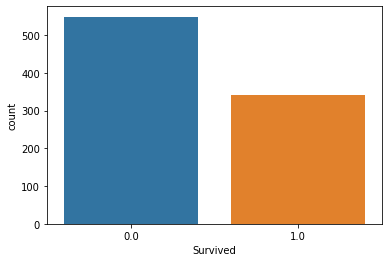

In [9]:
#先看存活率有多少
sns.countplot(data['Survived'])

<AxesSubplot:>

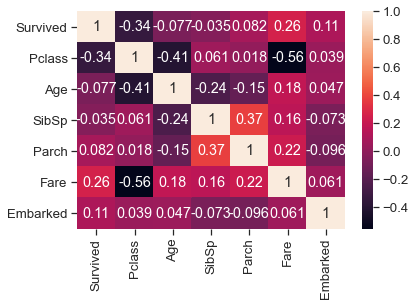

In [17]:
#各係數的相關係數
sns.heatmap(data.corr(), annot=True)

<font face="微软雅黑" size=3 color=#A52A2A > 尋找每一變數與存活率的關係

<AxesSubplot:xlabel='Pclass', ylabel='count'>

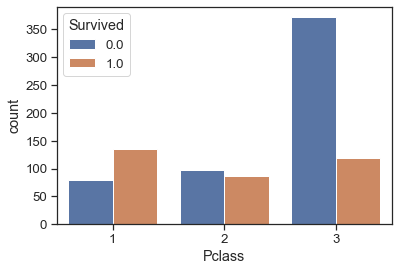

In [18]:
#倉等與存活率
sns.countplot(data['Pclass'], hue=data['Survived'])

<AxesSubplot:xlabel='Sex', ylabel='count'>

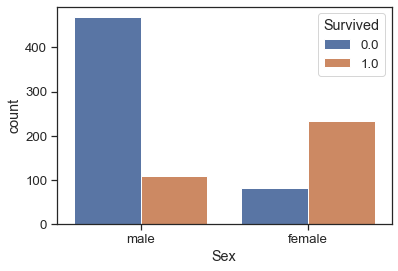

In [19]:
#性別與存活率
sns.countplot(data['Sex'], hue=data['Survived'])

<AxesSubplot:xlabel='Embarked', ylabel='count'>

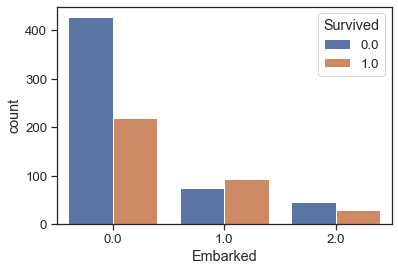

In [20]:
#出發港口與存活率
sns.countplot(data['Embarked'], hue=data['Survived'])

In [21]:
# Embarked value to fill missing value
embarked_dict = {'S':0,'C':1,'Q':2}
data.Embarked = data.Embarked.map(embarked_dict)
data.Embarked.fillna(data.Embarked.median(), inplace = True)

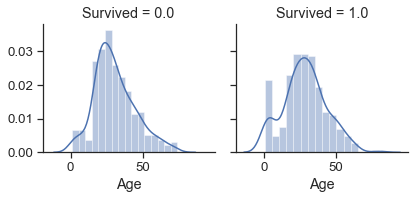

In [22]:
#年齡與存活率（分為男性及女性）
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Age')

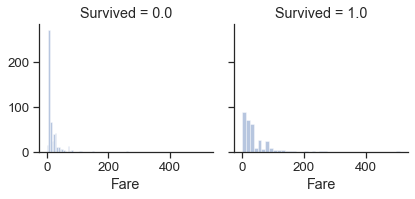

In [23]:
#票價與存活率
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Fare', kde=False)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

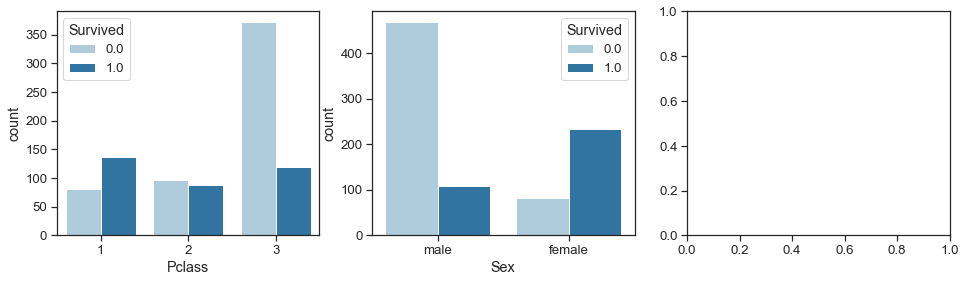

In [25]:
columns = ['Pclass', 'Sex','Embarked','SibSp', 'Parch','Survived']

plt.figure(figsize=(16, 14))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

for i, feature in enumerate(columns):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=data, x=feature, hue='Survived', palette='Paired')

sns.despine()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

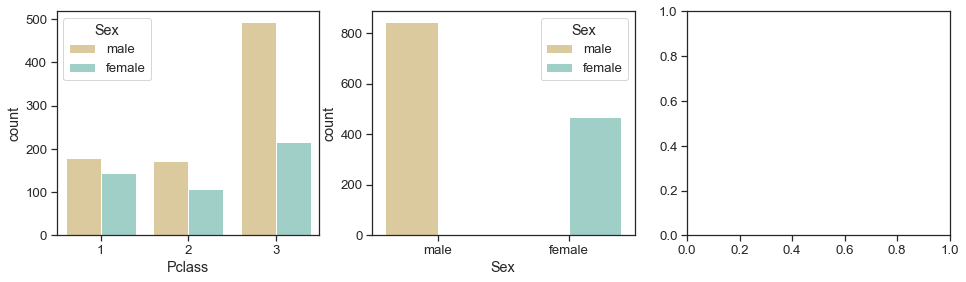

In [26]:
columns = ['Pclass', 'Sex','Embarked','SibSp', 'Parch','Survived']

plt.figure(figsize=(16, 14))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

for i, feature in enumerate(columns):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=data, x=feature, hue='Sex', palette='BrBG')
    
sns.despine()

<font face="微软雅黑" size=5 color=#A52A2A > 特徵工程

In [27]:
#sex
sex_dict = {'female':0, 'male':1}
data.Sex = data.Sex.map(sex_dict)

In [28]:
#Age
data.groupby(['Pclass','Sex','Survived'])['Age'].median()


Pclass  Sex  Survived
1       0    0.0         25.0
             1.0         35.0
        1    0.0         45.5
             1.0         36.0
2       0    0.0         32.5
             1.0         28.0
        1    0.0         30.5
             1.0          3.0
3       0    0.0         22.0
             1.0         19.0
        1    0.0         25.0
             1.0         25.0
Name: Age, dtype: float64

In [29]:
#Filling the missing values with mean of Pclass and Sex.
data["Age"].fillna(data.groupby(['Pclass','Sex'])['Age'].transform("mean"), inplace=True)

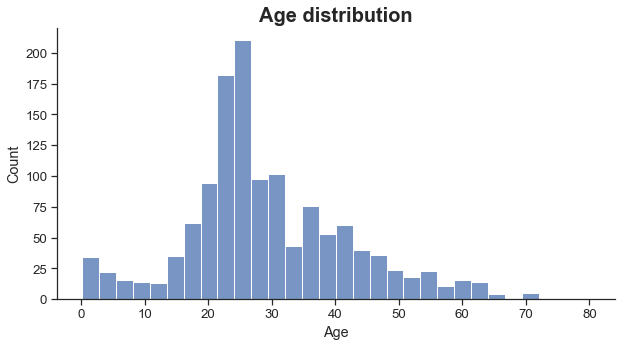

In [30]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.histplot(data=data, x='Age').set_title("Age distribution",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

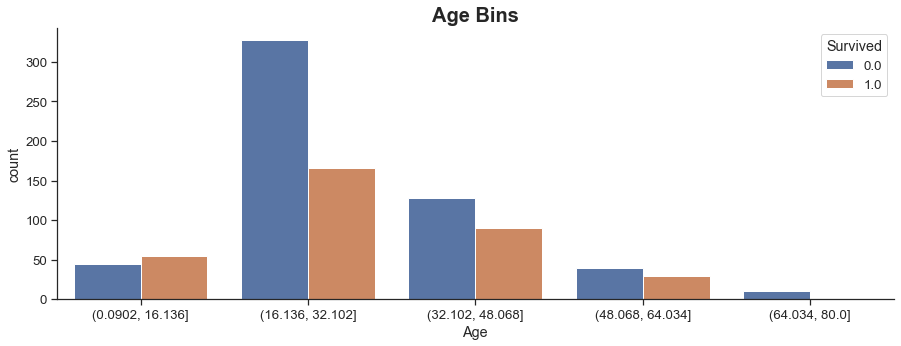

In [31]:
#spearate the age interval
auxage = pd.cut(data['Age'], 5)
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxage, hue='Survived', data=data).set_title("Age Bins",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()


In [32]:
# converting to categorical
data['Age'] = LabelEncoder().fit_transform(auxage) 
pd.crosstab(data['Age'], data['Survived'])

Survived,0.0,1.0
Age,,
0,45,55
1,327,166
2,128,90
3,39,30
4,10,1


Fare(票價)

Fare         
Survived    0.0      1.0
Pclass                  
1         44.75  77.9583
2         13.00  21.0000
3          8.05   8.5167

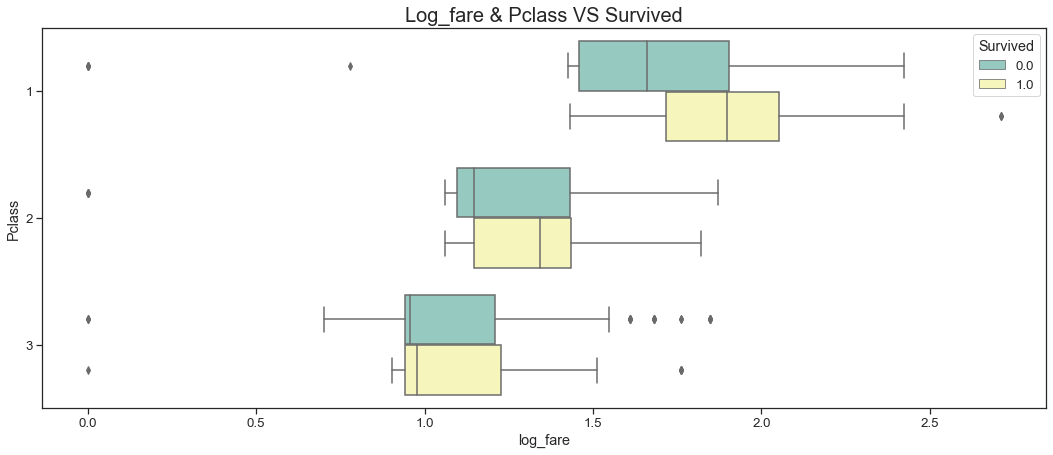

In [33]:
fig, ax = plt.subplots(figsize=(18, 7))
data['log_fare']= (data['Fare']+1).map(lambda x : np.log10(x) if x > 0 else 0)
sns.boxplot(y='Pclass', x='log_fare', hue='Survived', data= data, orient='h', ax=ax, palette='Set3')
ax.set_title('Log_fare & Pclass VS Survived', fontsize=20)
pd.pivot_table(data, values=['Fare'], index=['Pclass'], columns=['Survived'], aggfunc='median')

In [34]:
#Filling the missing values
data["Fare"].fillna(data.groupby(['Pclass', 'Sex'])['Fare'].transform("median"), inplace=True)

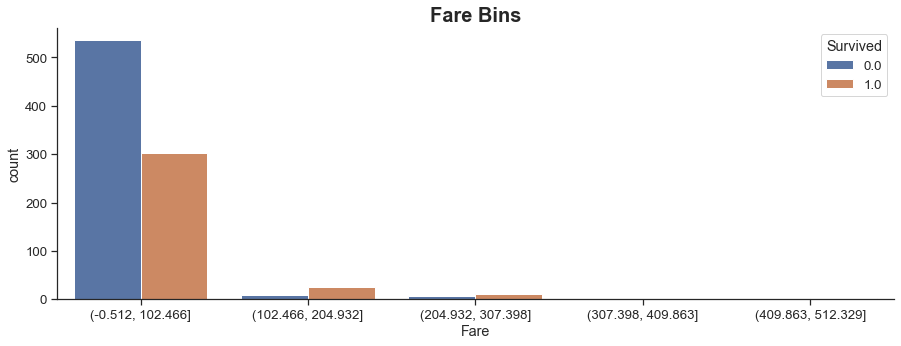

In [35]:
auxfare = pd.cut(data['Fare'],5)
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxfare, hue='Survived', data=data).set_title("Fare Bins",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

In [36]:
data['Fare'] = LabelEncoder().fit_transform(auxfare)
pd.crosstab(data['Fare'], data['Survived'])

Survived,0.0,1.0
Fare,,
0,535,303
1,8,25
2,6,11
3,0,3


<font face="微软雅黑" size=5  >  Data Extraction

In [37]:
#Title
data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand = False)

In [38]:
data.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Mlle          2
Ms            2
Capt          1
Sir           1
Countess      1
Lady          1
Don           1
Mme           1
Jonkheer      1
Dona          1
Name: Title, dtype: int64

In [39]:
least_occuring = ['Rev','Dr','Major', 'Col', 'Capt','Jonkheer','Countess']

data.Title = data.Title.replace(['Ms', 'Mlle','Mme','Lady'], 'Miss')
data.Title = data.Title.replace(['Countess','Dona'], 'Mrs')
data.Title = data.Title.replace(['Don','Sir'], 'Mr')

data.Title = data.Title.replace(least_occuring,'Rare')

data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [40]:
pd.crosstab(data['Title'], data['Survived'])

Survived,0.0,1.0
Title,,
Master,17,23
Miss,55,132
Mr,437,82
Mrs,26,100
Rare,14,5


In [41]:
data['Title'] = LabelEncoder().fit_transform(data['Title']) 

In [42]:
data['LastName'] = last= data.Name.str.extract('^(.+?),', expand = False)

In [43]:
#from sex and title data to comfirm the women and children.
data['WomChi'] = ((data.Title == 0) | (data.Sex == 0))

In [44]:
family = data.groupby([data.LastName, data.Pclass, data.Ticket]).Survived

data['FTotalCount'] = family.transform(lambda s: s[data.WomChi].fillna(0).count())
data['FTotalCount'] = data.mask(data.WomChi, (data.FTotalCount - 1), axis=0)

data['FSurvivedCount'] = family.transform(lambda s: s[data.WomChi].fillna(0).sum())
data['FSurvivedCount'] = data.mask(data.WomChi, data.FSurvivedCount - data.Survived.fillna(0), axis=0)

data['FSurvivalRate'] = (data.FSurvivedCount / data.FTotalCount.replace(0, np.nan))

In [45]:
# filling the missing values
data.FSurvivalRate.fillna(0, inplace = True)
data.FTotalCount.fillna(0, inplace = True)
data.FSurvivedCount.fillna(0, inplace = True)

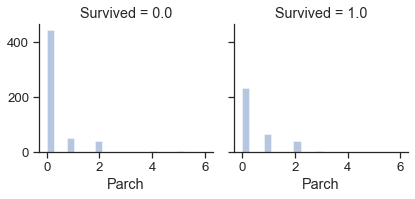

In [46]:
#父母與小孩有無在一起與存活率
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Parch', kde=False)

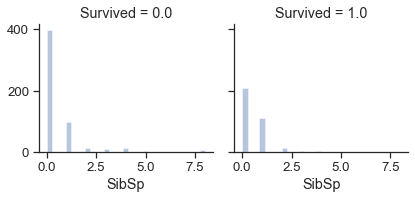

In [47]:
#有兄弟姐妹的或者妻子丈夫的與存活率
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'SibSp', kde=False)

由於有無父母及有無兄親屬的關係，均為相同趨勢，且不互相影響，故可將Parch + SibSp的數量相加
生成新的變數家庭大小

In [48]:
data['Fm_size'] = data['Parch'] + data['SibSp'] + 1
#還要算自己一個所以要＋1

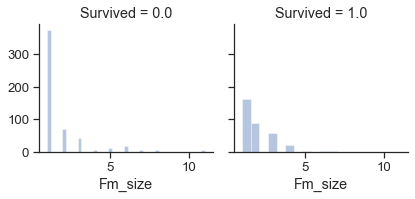

In [49]:
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Fm_size', kde=False)

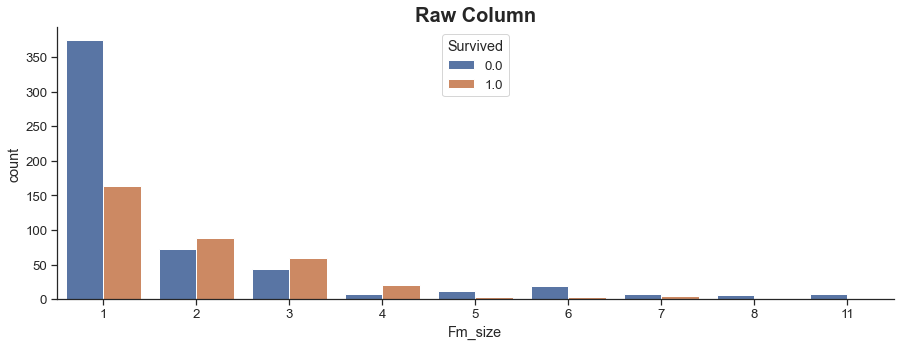

In [50]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x='Fm_size', hue='Survived', data=data).set_title("Raw Column",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

In [51]:
# Binning FamilySize column
data.loc[ data['Fm_size'] == 1, 'Fm_size'] = 0                            # Alone
data.loc[(data['Fm_size'] > 1) & (data['Fm_size'] <= 4), 'Fm_size'] = 1  # Small Family 
data.loc[(data['Fm_size'] > 4) & (data['Fm_size'] <= 6), 'Fm_size'] = 2  # Medium Family
data.loc[data['Fm_size']  > 6, 'Fm_size'] = 3                             # Large Family 

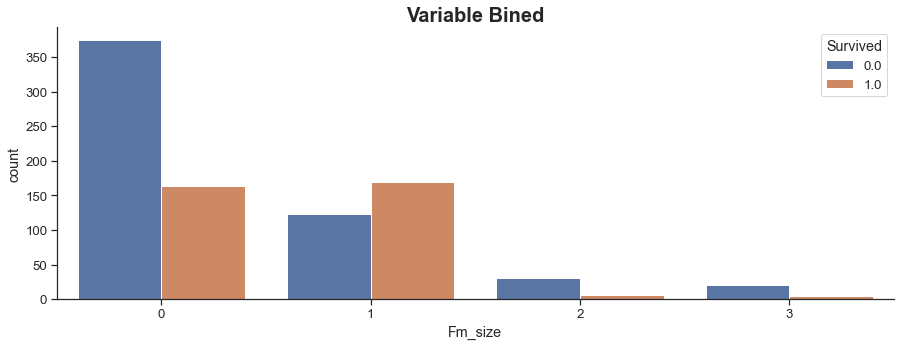

In [52]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x='Fm_size', hue='Survived', data=data).set_title("Variable Bined",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

In [53]:
#Ticket
train['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

從上面分析可知道，持有相同票根的人會座落在同一區，由此來建立不同家庭組成，以探討其生存關係。

In [54]:
#Ticket data transfer to number.
data['Ticket'] = data.Ticket.str.split().apply(lambda x : 0 if x[:][-1] == 'LINE' else x[:][-1])
data.Ticket = data.Ticket.values.astype('int64')

In [55]:
#Cabin value is too much missing,so I drop the data.
data.drop(['Cabin'], axis = 1, inplace = True)

In [56]:
data.isna().sum()

Survived           418
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Embarked          1309
log_fare             0
Title                0
LastName             0
WomChi               0
FTotalCount          0
FSurvivedCount       0
FSurvivalRate        0
Fm_size              0
dtype: int64

<font face="微软雅黑" size=5 color=#A52A2A > 建立模型

In [57]:
data['PassengerId'] = data.index

In [58]:
df = pd.get_dummies(data, columns=['Sex', 'Fare', 'Pclass'])

In [59]:
df.drop(['Name','LastName','WomChi','FTotalCount','FSurvivedCount','Embarked','Title'], axis = 1, inplace = True)

In [60]:
df.columns

Index(['Survived', 'Age', 'SibSp', 'Parch', 'Ticket', 'log_fare',
       'FSurvivalRate', 'Fm_size', 'PassengerId', 'Sex_0', 'Sex_1', 'Fare_0',
       'Fare_1', 'Fare_2', 'Fare_3', 'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [68]:
df.loc[len(train):]

,Survived,Age,SibSp,Parch,Ticket,log_fare,FSurvivalRate,Fm_size,PassengerId,Sex_0,Sex_1,Fare_0,Fare_1,Fare_2,Fare_3,Pclass_1,Pclass_2,Pclass_3
891,NaN,2,0,0,330911,0.945921,0.0,0,891,0,1,1,0,0,0,0,0,1
892,NaN,2,1,0,363272,0.903090,0.0,1,892,1,0,1,0,0,0,0,0,1
893,NaN,3,0,0,240276,1.028876,0.0,0,893,0,1,1,0,0,0,0,1,0
894,NaN,1,0,0,315154,0.985090,0.0,0,894,0,1,1,0,0,0,0,0,1
895,NaN,1,1,1,3101298,1.123443,1.0,1,895,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,1,0,0,3236,0.956649,0.0,0,1304,0,1,1,0,0,0,0,0,1
1305,NaN,2,0,0,17758,2.040998,0.0,0,1305,1,0,0,1,0,0,1,0,0
1306,NaN,2,0,0,3101262,0.916454,0.0,0,1306,0,1,1,0,0,0,0,0,1
1307,NaN,1,0,0,359309,0.956649,0.0,0,1307,0,1,1,0,0,0,0,0,1


In [69]:
# I splitted df to train and test
train, test = df.loc[:len(train)-1], df.loc[len(train):]

X_train = train.drop(['PassengerId','Survived'], axis = 1)
Y_train = train["Survived"]
train_names = X_train.columns

X_test = test.drop(['PassengerId','Survived'], axis = 1)

In [70]:
# Scaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [71]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

93.38

In [72]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

93.94

In [73]:
#KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

96.07

In [74]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.8

In [75]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

91.25

In [76]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

93.38

In [77]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

87.88

In [78]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

100.0

In [84]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=50)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

100.0

In [80]:

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X_train, Y_train,
                                                                    test_size=0.25,stratify=Y_train,random_state=0)
eval_set = [(train_x,train_y),(valid_x,valid_y)]

In [81]:

xgbc = XGBClassifier(objective='binary:logistic', learning_rate=1)
xgbc.fit(X_train, Y_train,eval_metric=['auc'],eval_set=eval_set,verbose=True)
Y_pred = xgbc.predict(X_test)
xgbc.score(X_train, Y_train)
acc_xgb = round(xgbc.score(X_train, Y_train) * 100, 2)
acc_xgb

[99]	validation_0-auc:0.99999	validation_1-auc:1.00000


99.89

In [82]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'XGBoost'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree, acc_xgb]})
models.sort_values(by='Score', ascending=False)


,Model,Score
8,Decision Tree,100.00
3,Random Forest,99.89
9,XGBoost,99.89
1,KNN,96.07
0,Support Vector Machines,93.94
2,Logistic Regression,93.38
7,Linear SVC,93.38
5,Perceptron,91.25
6,Stochastic Gradient Decent,87.88
4,Naive Bayes,79.80


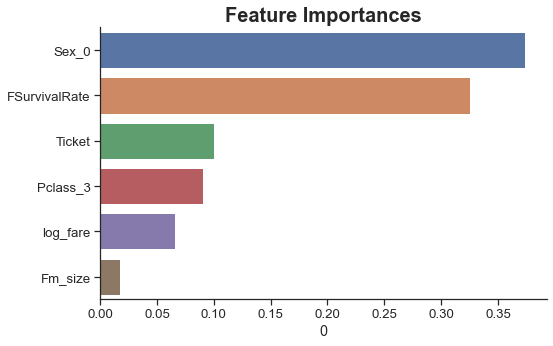

In [83]:
importances = pd.DataFrame(decision_tree.feature_importances_, index = train_names)
importances.sort_values(by = 0, inplace=True, ascending = False)
importances = importances.iloc[0:6,:] 

plt.figure(figsize=(8, 5)) 
sns.barplot(x=0, y=importances.index, data=importances,palette="deep").set_title("Feature Importances",
                                                                                 fontdict= { 'fontsize': 20,
                                                                                            'fontweight':'bold'});
sns.despine()

In [87]:
submit = pd.DataFrame({"PassengerId":test.PassengerId + 1, 'Survived':Y_pred.astype(int).ravel()})
submit.to_csv("submission.csv",index = False)

the result get 0.79655 score.
next step to check the data preprocessing.

ref:
    1.https://www.kaggle.com/javiervallejos/titanic-top-3?select=gender_submission.csv
    2.https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial